In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

In [2]:
device = "mps"

In [3]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 16 * 16, 300)  # For mean
        self.fc_logvar = nn.Linear(128 * 16 * 16, 300)  # For log variance

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(300, 128 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = x.view(-1, 128, 16, 16)  # Reshape to match the encoder's last conv layer output shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # Use sigmoid for the last layer if images are normalized between [0,1]
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [5]:
from torch.utils.tensorboard import SummaryWriter
def train(vae, data, epochs=20, initial_lr=0.001, anneal_factor=0.5, anneal_epochs=10, name="vae_training"):
    opt = torch.optim.Adam(vae.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=anneal_epochs, gamma=anneal_factor)
    
    writer = SummaryWriter(log_dir=f"results/{name}")  # Create a SummaryWriter object for TensorBoard
    
    for epoch in range(epochs):
        losses = 0
        for x in data:
            x = x.to(device)  # Assuming 'device' is defined (e.g., 'cuda' or 'cpu')
            opt.zero_grad()
            x_hat, mu, logvar = vae(x)
            # Reconstruction loss
            recon_loss = F.mse_loss(x_hat, x, reduction='sum')
            # KL divergence
            kld = -0.05 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            # Total loss
            loss = recon_loss + kld
            losses += loss.item()
            loss.backward()
            opt.step()
        
        scheduler.step()  # Update learning rate
        
        # Write loss and learning rate to TensorBoard
        writer.add_scalar('Reconstruction Loss', recon_loss.item(), epoch)
        writer.add_scalar('KL Divergence', kld.item(), epoch)
        writer.add_scalar('Learning Rate', scheduler.get_lr()[0], epoch)
        
        print(f"Epoch {epoch+1}, Loss: {loss.item()}, Learning Rate: {scheduler.get_lr()[0]}")
    
    writer.close()  # Close the SummaryWriter
    
    return vae

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img, name):
    """
    Helper function to unnormalize and display an image
    """
    if "resultImages" not in os.listdir():
        os.mkdir("resultImages")
    img = img / 2 + 0.5  # unnormalize if you used normalization in your transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imsave(f"resultImages/{name}.png", np.transpose(npimg, (1, 2, 0)))

def show_images(autoencoder, data_set, device, env):
    """
    Show original and reconstructed images.
    
    Parameters:
    - autoencoder: the trained autoencoder model.
    - data_loader: PyTorch DataLoader containing the dataset.
    - device: PyTorch device to use ('cuda' or 'cpu').
    """
    # Get a batch of images
    image = data_set[random.randint(0, len(data_set))]
    images = image.unsqueeze(0)

    # Move images to the device
    images = images.to(device)

    # Forward pass through the autoencoder
    reconstructed, _, _ = autoencoder(images) # detach to avoid tracking history in autograd
    reconstructed = reconstructed.detach()

    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Display original images
    print("Original Images")
    imshow(torchvision.utils.make_grid(images), f"{env}_original")

    # Display reconstructed images
    print("Reconstructed Images")
    imshow(torchvision.utils.make_grid(reconstructed), f"{env}_reconstructed")

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C32H1W32768 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C16H1W32768 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
/Users/cowolff/miniconda3/envs/Ray/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:389: UserWarn

Epoch 1, Loss: 26609.515625, Learning Rate: 0.001
Epoch 2, Loss: 3918.392822265625, Learning Rate: 0.001
Epoch 3, Loss: 2876.921875, Learning Rate: 0.001
Epoch 4, Loss: 2764.923828125, Learning Rate: 0.001
Epoch 5, Loss: 2110.52197265625, Learning Rate: 0.001
Epoch 6, Loss: 1879.6595458984375, Learning Rate: 0.001
Epoch 7, Loss: 1611.83935546875, Learning Rate: 0.001
Epoch 8, Loss: 1319.81982421875, Learning Rate: 0.001
Epoch 9, Loss: 1376.802490234375, Learning Rate: 0.001
Epoch 10, Loss: 1089.243896484375, Learning Rate: 0.00025
Epoch 11, Loss: 1210.3438720703125, Learning Rate: 0.0005
Epoch 12, Loss: 1196.037841796875, Learning Rate: 0.0005
Epoch 13, Loss: 1188.4696044921875, Learning Rate: 0.0005
Epoch 14, Loss: 1046.5050048828125, Learning Rate: 0.0005
Epoch 15, Loss: 993.2295532226562, Learning Rate: 0.0005
Epoch 16, Loss: 1021.7545776367188, Learning Rate: 0.0005
Epoch 17, Loss: 961.159423828125, Learning Rate: 0.0005
Epoch 18, Loss: 965.881103515625, Learning Rate: 0.0005
Epoch

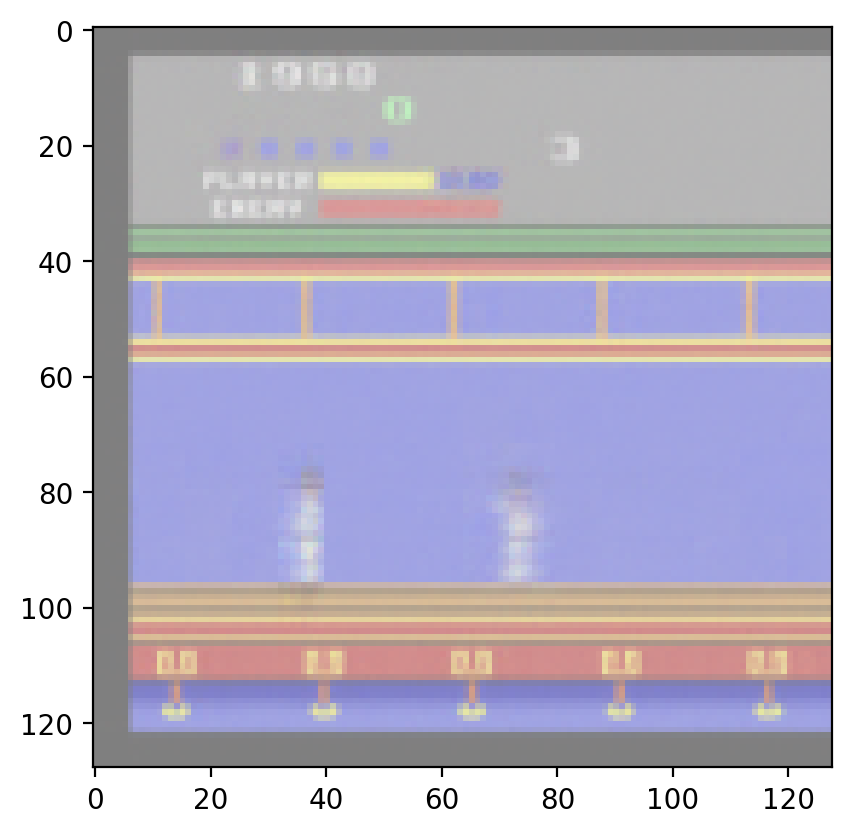

In [7]:
num_epochs = 90
device = "mps"

class Dataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, img) for img in os.listdir(directory)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])

for env in os.listdir("images"):
# for env in ["BoxingNoFrameskip-v4"]:
    dataset = Dataset(directory=f'images/{env}', transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    autoencoder = VAE().to(device)
    autoencoder = train(autoencoder, dataloader, num_epochs, name=env)

    test_dataset = Dataset(directory=f'images/{env}', transform=transform)

    show_images(autoencoder, test_dataset, device, str(env))

    torch.save(autoencoder.state_dict(), f"models/{env}_vae_{100}.pth")